# KPrototypes(n=4) Results

From the previous notebook, we have identified that `n=4` is the optimum number of clusters.  
In this notebook, we will explore what the `4` individual clusters represent.

**Setting up**

In [56]:
%load_ext kedro.ipython
%load_ext autoreload
%matplotlib inline
%autoreload 2

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import pandas as pd
import polars as pl
import numpy as np

from matplotlib import rc_context
import matplotlib.pyplot as plt
import seaborn as sb
from seaborn.objects import Plot
import seaborn.objects as so

from kmodes.kprototypes import KPrototypes

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

In [58]:
X: pd.DataFrame = catalog.load('train')
scaler = catalog.load('model@scaler')

[04/16/23 13:04:31] INFO     Loading data from 'train' (CSVDataSet)...                          ]8;id=153356;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=668739;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'model@scaler' (PickleDataSet)...                ]8;id=197657;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=899720;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [71]:
def cluster(n=1):
  model = KPrototypes(n_clusters = n, n_jobs = -1, random_state = 0)
  log.info("Performing clustering for n=%d", n)
  y = model.fit_predict(X=X[columns], categorical=list(range(0, len(categorical))))
  log.info("cost[%d]=%.2f", n, model.cost_)
  return model, y

model = None
y = None
if catalog.exists('model@kprototypes@4'):
    model = catalog.load('model@kprototypes@4')
    y = catalog.load('labels@kprototypes@4')
else:
    model, y = cluster(n=4)
    catalog.save('model@kprototypes@4', model)
    catalog.save('labels@kprototypes@4', pd.Series(y, name='cluster'))

X['cluster'] = y

[04/16/23 16:25:52] INFO     Loading data from 'model@kprototypes' (PickleDataSet)...           ]8;id=660866;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=986290;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'labels@kprototypes' (CSVDataSet)...             ]8;id=283915;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=569634;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [101]:
X = X.set_index('appid')
X['cluster'] = X['cluster'].astype(pd.CategoricalDtype(categories=[0,1,2,3]))

# Centroids

In [72]:
centroids_u = pd.DataFrame(model.cluster_centroids_, columns=numerical+categorical) # KPrototypes handles categorical last
centroids_u

,year,achievements,required_age,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,...,median_playtime,english,windows,mac,linux,Single-player,Multi-player,Indie,Action,Casual
0,0.998818,0.004992,0.000276,0.012988,0.000542,0.134761,0.183745,1.000000,0.000138,0.000226,...,0.000684,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.998885,0.004525,0.000571,0.011011,0.000144,0.120526,0.094726,0.596217,0.000006,0.000019,...,0.000073,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.998179,0.003236,0.921191,0.029281,0.005465,0.223292,0.156852,0.991243,0.003216,0.003703,...,0.002002,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.998597,0.003664,0.000234,0.018538,0.002004,0.349317,0.192355,0.998540,0.000964,0.000902,...,0.001184,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [76]:
centroids = pd.DataFrame(scaler.inverse_transform(centroids_u[scaler.feature_names_in_]), columns=scaler.feature_names_in_)
centroids.round(2)

,english,windows,mac,linux,Single-player,Multi-player,Indie,Action,Casual,year,...,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime
0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2016.61,...,5.48,108438.35,2.43,2.94,3.00,365.15,110.01,4.49,116.25,130.34
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2016.75,...,4.65,28838.54,2.17,1.52,1.79,15.66,9.49,2.31,13.38,13.83
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2015.32,...,12.36,1093012.26,4.02,2.51,2.97,8504.74,1803.82,5.71,572.10,381.60
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2016.17,...,7.82,400757.38,6.29,3.08,3.00,2550.31,439.52,5.88,265.18,225.71


In [177]:
counts = X['cluster'].value_counts()

viz = centroids_u.reset_index(names='cluster').melt(id_vars='cluster')
viz['categorical'] = viz['variable'].map(lambda x: x in categorical)
centroid_viz_data = (viz
                     .reset_index(names='order')
                     .set_index(['cluster', 'variable'])
                     .join(centroids
                           .reset_index(names='cluster')
                           .melt(id_vars='cluster', value_name='orig')
                           .set_index(['cluster', 'variable'])
                           .round(2)
                     )
                     .reset_index('cluster')
                     .join(X[columns].median()
                           .to_frame('median'),
                           how='left'
                     )
                     .reset_index(names='variable')
                     .set_index('cluster')
                     .sort_values(by='order'))

def centroid_viz(cluster=0):
    df = centroid_viz_data.loc[cluster].reset_index(drop=True)
    return (Plot(data=df, y="variable", x="value", color="categorical")
    .add(so.Bar(width=0.05, color="lightgrey", alpha=0.6), baseline="median", legend=False)
    .add(so.Dot())
    .add(so.Dot(alpha=0.6), x="median")
    .add(so.Text(halign="left", fontsize=8, offset=8, color="black"), text="orig")
    .label(title=f"Visualisation of cluster {cluster} centroid (n={counts[cluster]})")
    .limit(x=(-0.05,1.2)))

In [159]:
cluster_viz_data = X.melt(id_vars='cluster')#.set_index('cluster')

def cluster_viz(cluster=0):
    df = cluster_viz_data.set_index('cluster').loc[cluster].reset_index(drop=True)
    return (sb.catplot(data=df, 
                       x='value', 
                       y='variable', 
                       kind='box', 
                       fliersize=2, 
                       flierprops={"marker": "x"}, 
                       medianprops={"color": "orange"}, 
                       showcaps=False)
            .set(title=f"Visualisation of cluster {cluster} (n={counts[cluster]})"))

## At a glance

**Number of games per cluster**

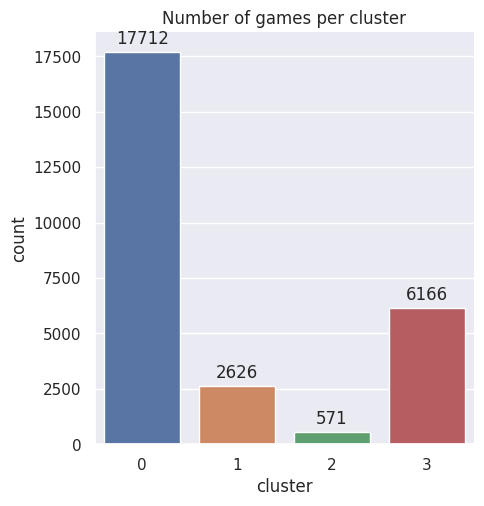

In [102]:
catplot_xlabel(sb.catplot(data=X, x='cluster', kind='count').set(title="Number of games per cluster"))

**Centroid visualisation**

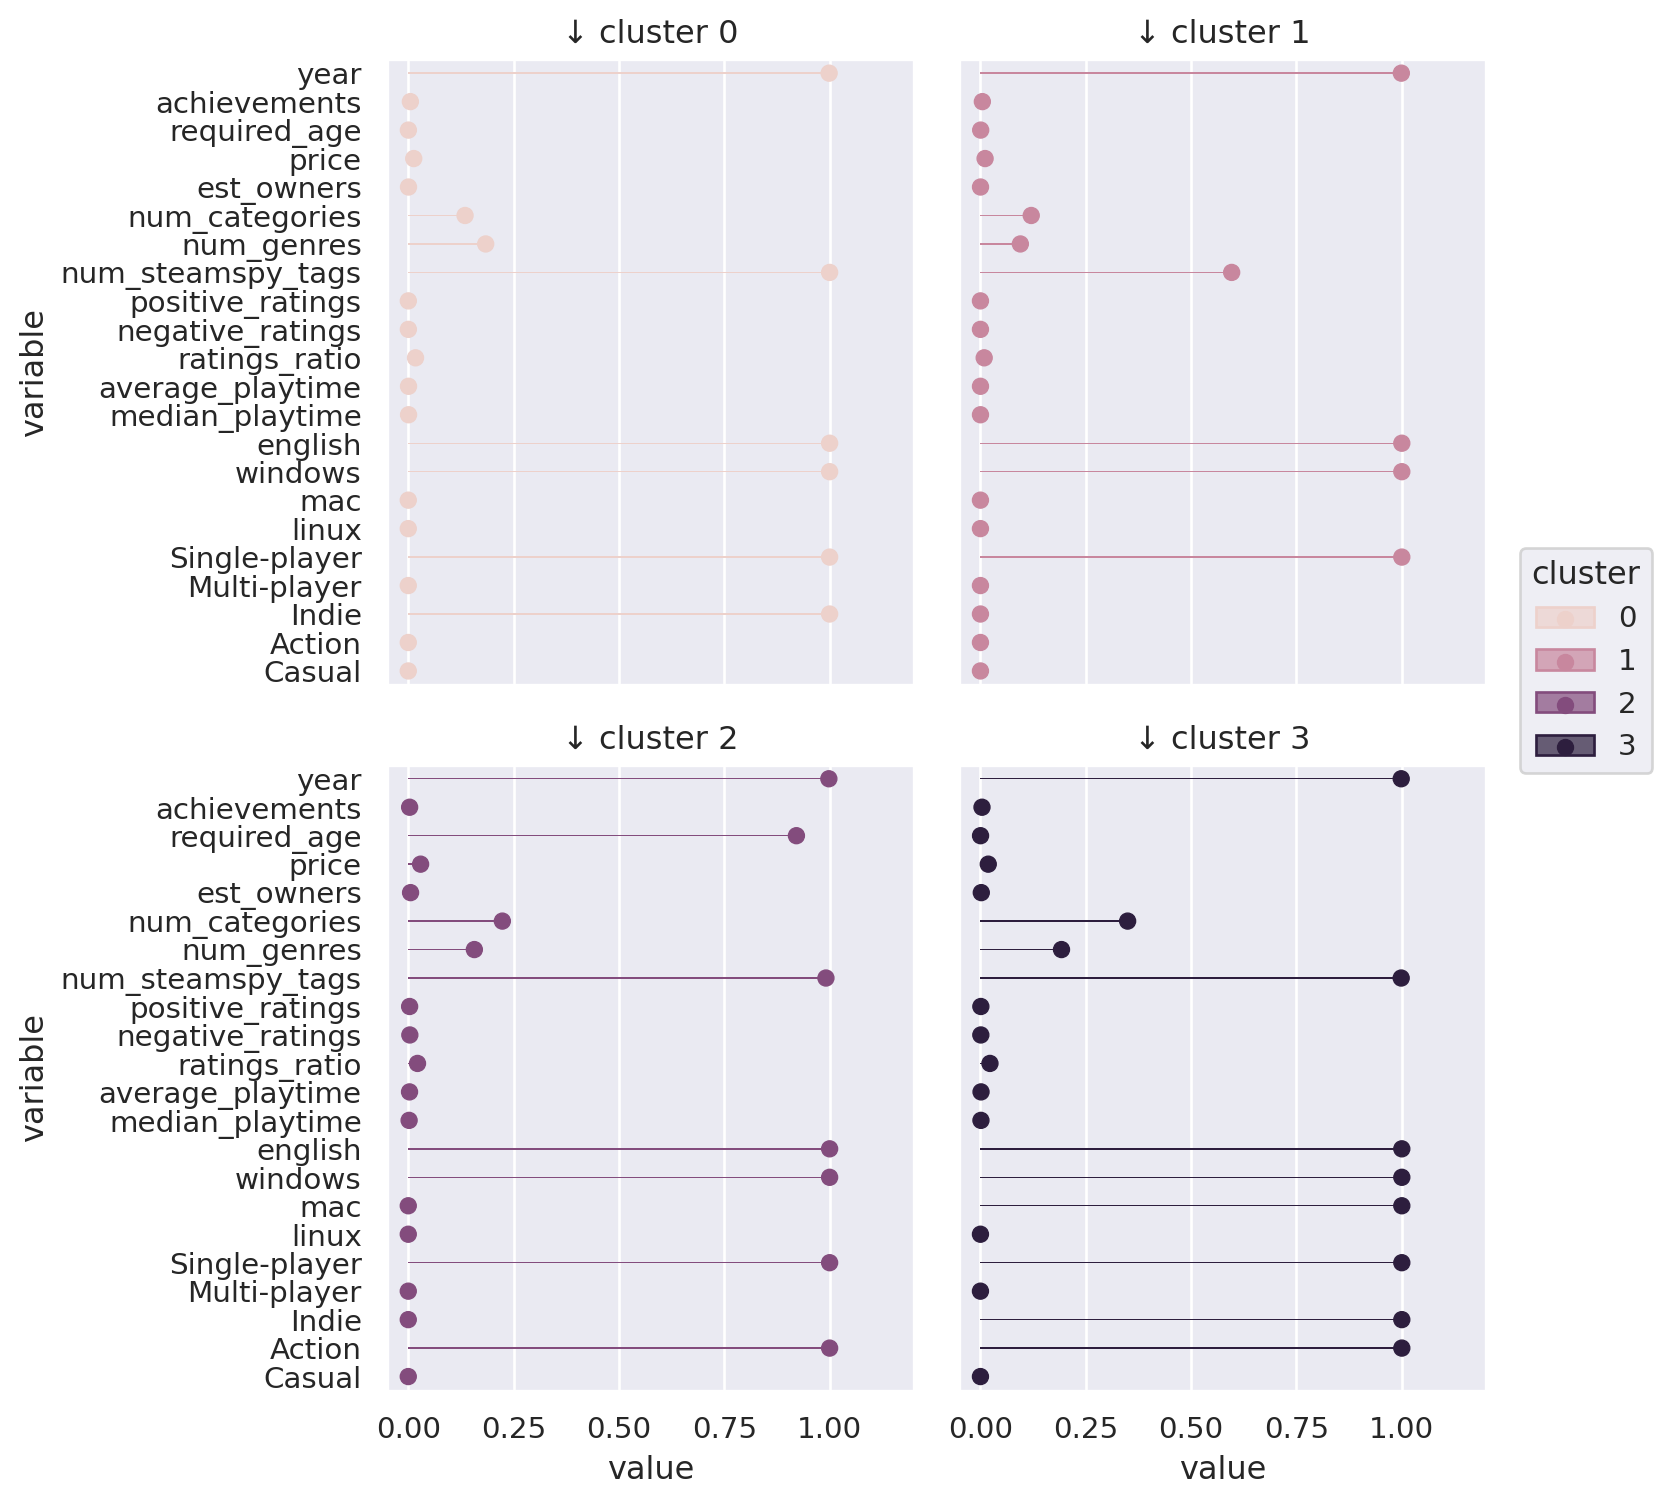

In [178]:
(Plot(data=centroid_viz_data.reset_index(), y="variable", x="value", color="cluster")
 .limit(x=(-0.05,1.2))
 .layout(size=(8,8))
 .facet(col="cluster", wrap=2)
 .add(so.Bar(width=0.05))
 .add(so.Dot())
 .label(col="↓ cluster"))

**Distribution per feature by cluster visualisation**

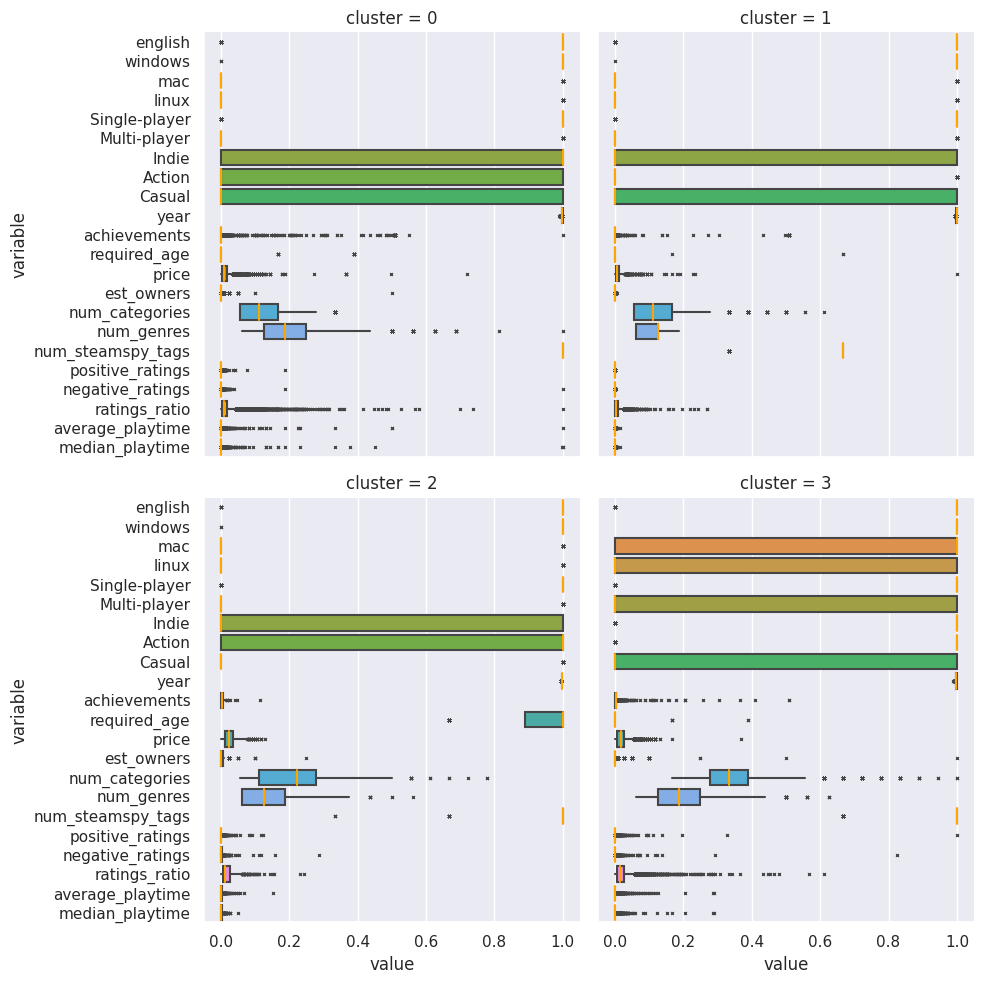

In [152]:
sb.catplot(data=cluster_viz_data, x='value', y='variable', col='cluster', col_wrap=2, kind='box', fliersize=2, flierprops={"marker": "x"}, medianprops={"color": "orange"}, showcaps=False)

# Cluster 0

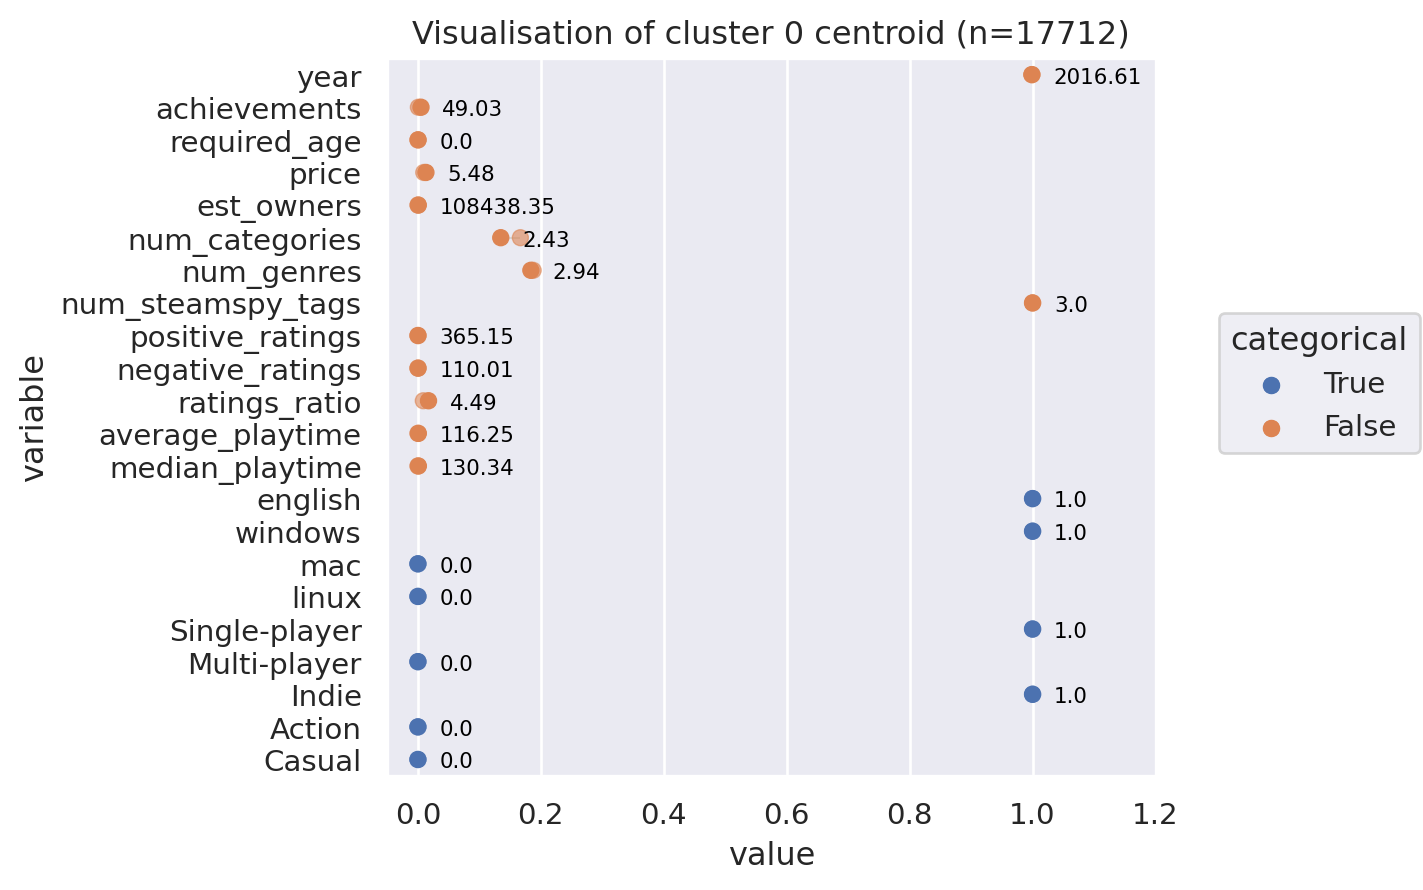

In [179]:
centroid_viz(0)

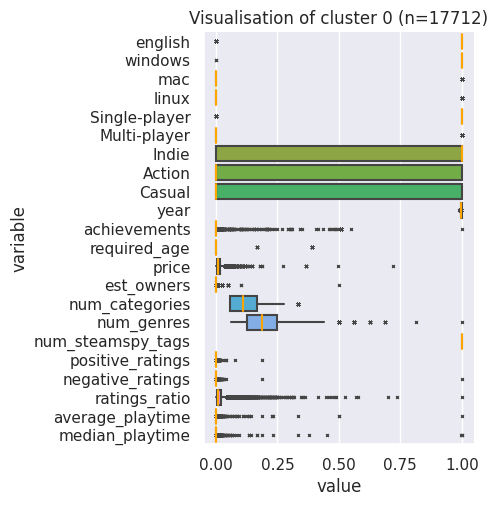

In [160]:
cluster_viz(0)

# Cluster 1

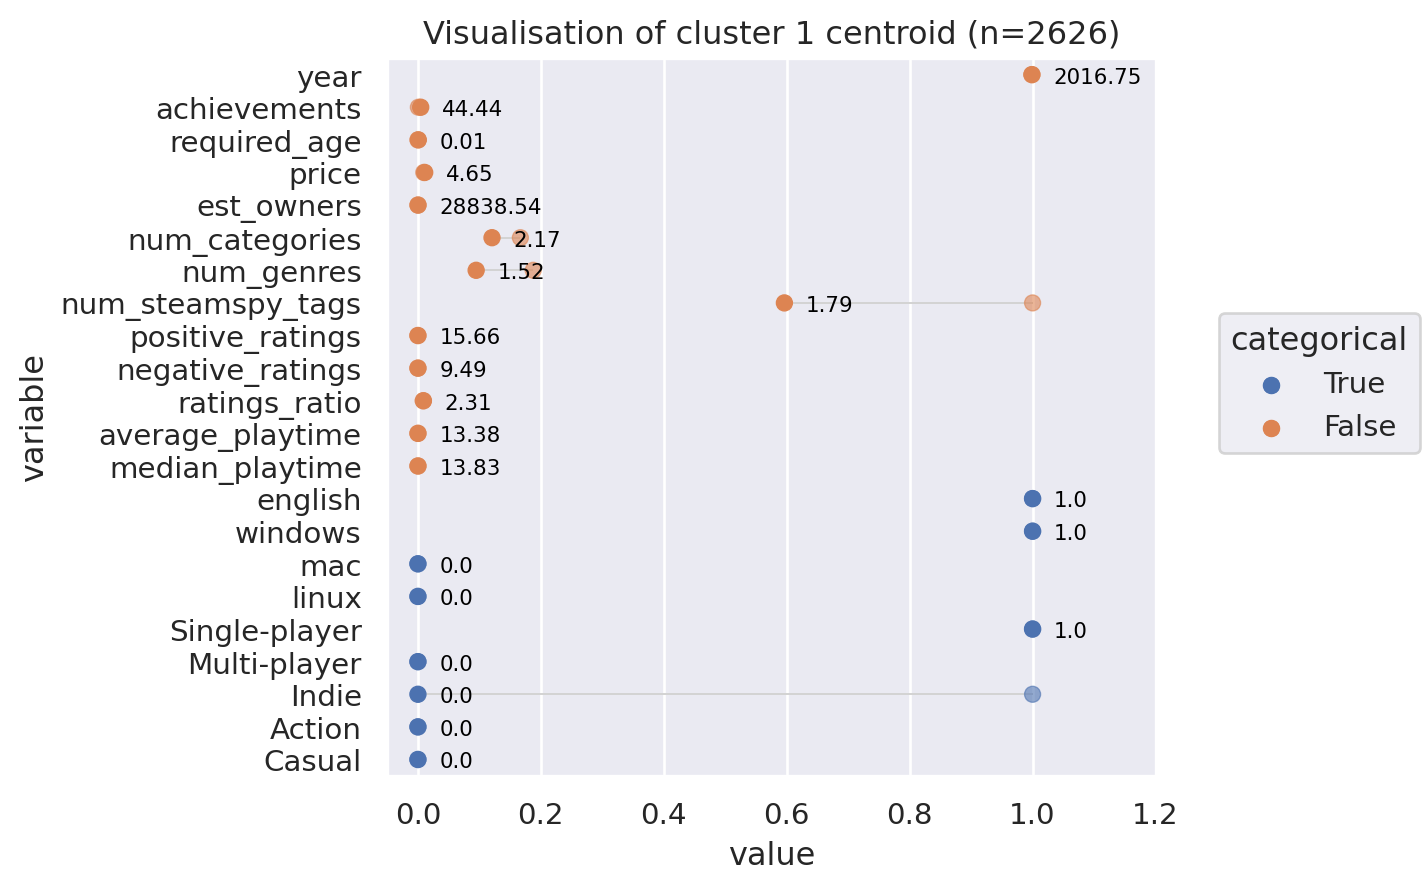

In [180]:
centroid_viz(1)

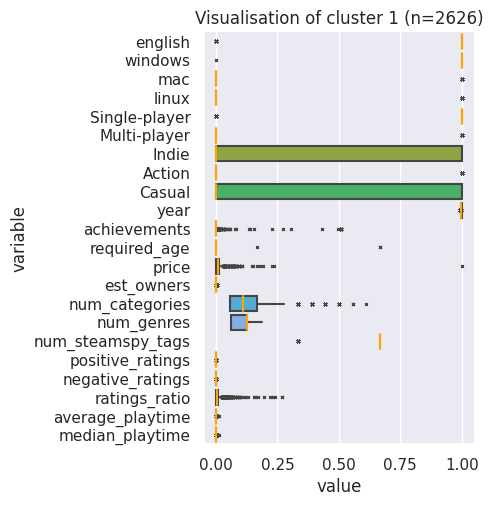

In [162]:
cluster_viz(1)

# Cluster 2

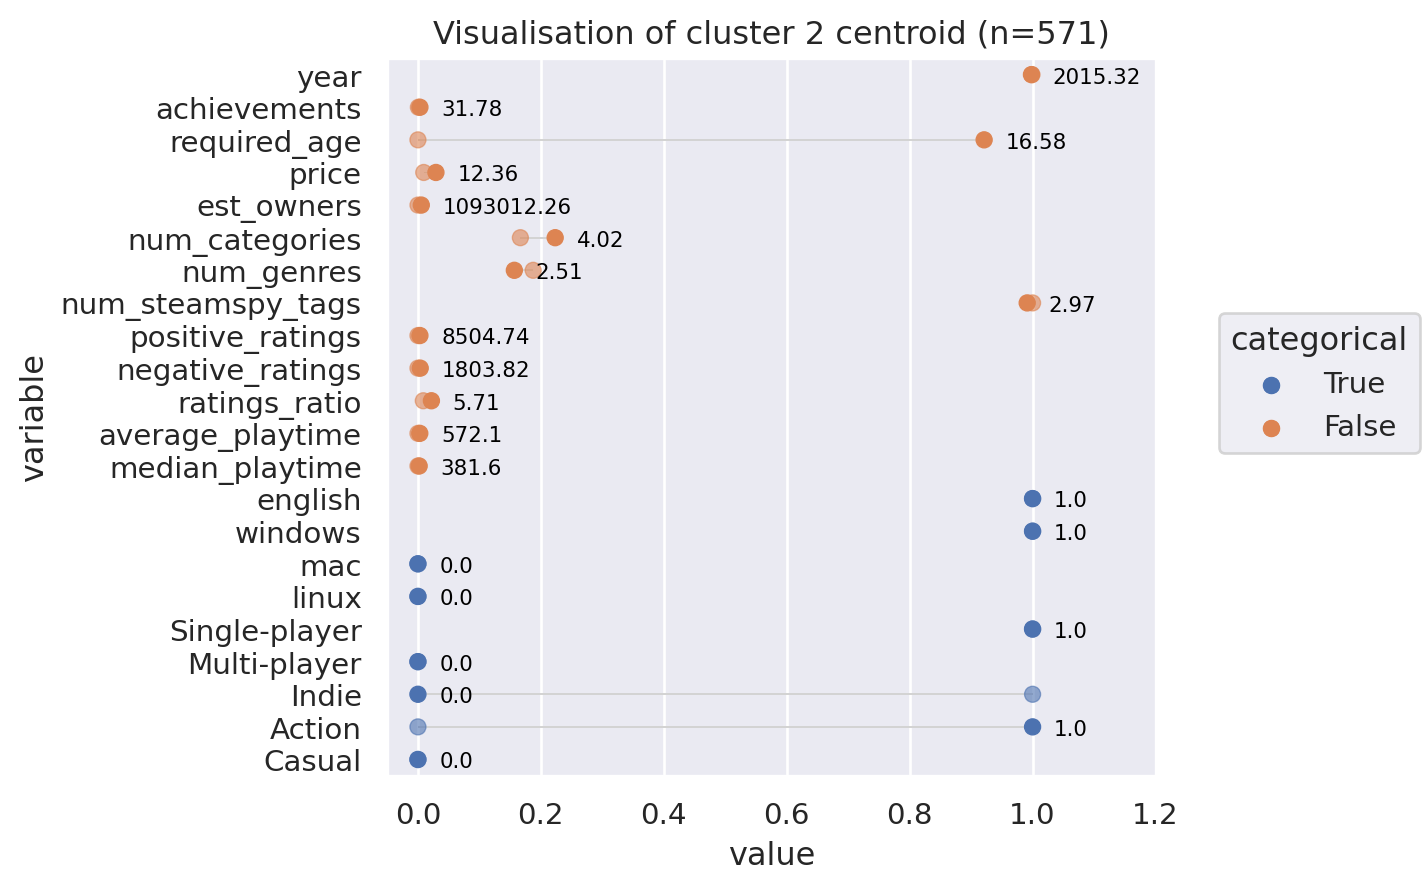

In [181]:
centroid_viz(2)

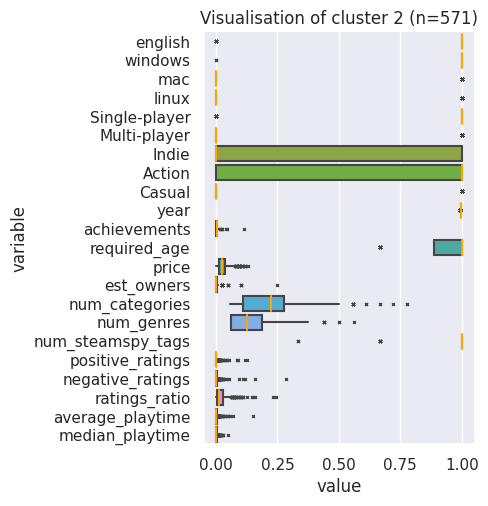

In [164]:
cluster_viz(2)

# Cluster 3

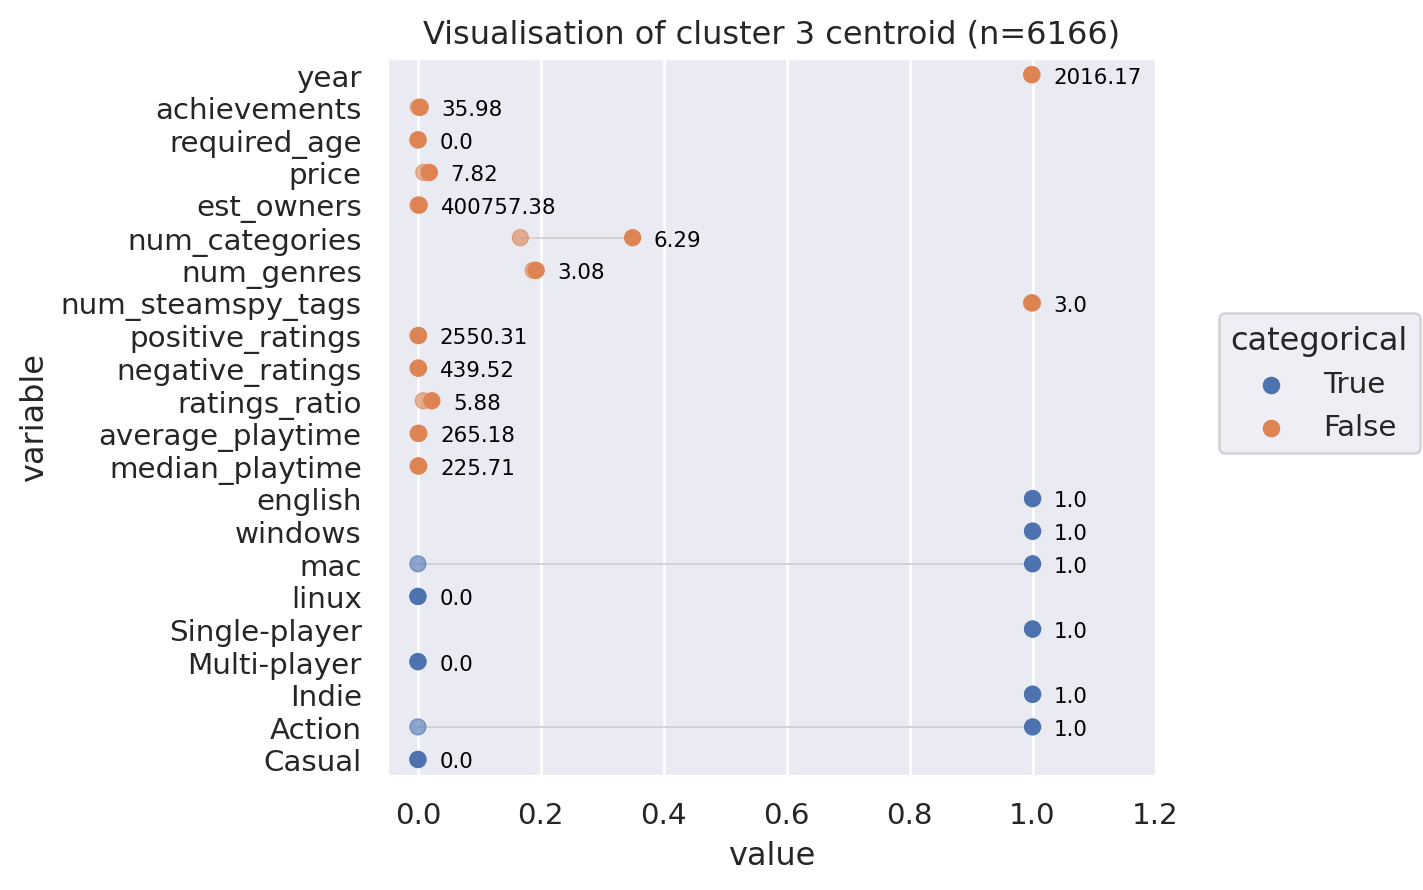

In [182]:
centroid_viz(3)

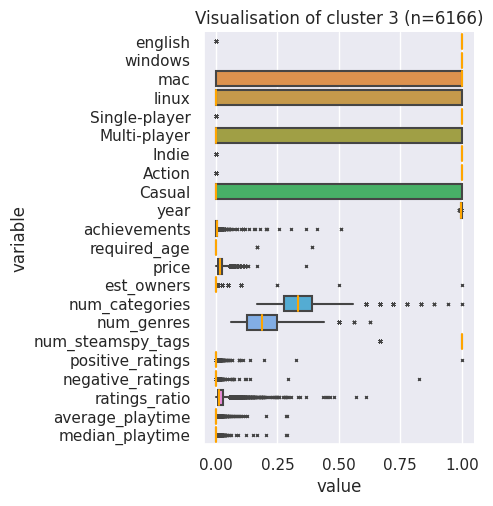

In [183]:
cluster_viz(3)

# Summary

We think that it is not ideal for so much of the data to end up in `cluster 0` as it does not help us carve out meaning from the data. Hence, we skipped analysis for `n=4`